# Lagged daily raster summarisation and point sampling

### Description of the datasets

We have a point dataset, in the form of a CSV file with lat/lon columns. 

Each row in the dataset represents a household as surveyed on a specific date. (In this instance the data are extracted from DHS household surveys.)

Each household has a location (lat/lon) but many households are at the same location (for anonymity); the location is known as a cluster and is unique by surveyid and cluster_number. 

Numerous households will generally be surveyed on the same day, but not necessarily all those at a given location (cluster), and the households in one day will likely be spread across numerous clusters.

We have a folder of rasters which represent DAILY data for a single variable of interest (i.e. one raster per day). Specifically, these are daily rainfall grids from the CHIRPS datasets. These are named such that the filename contains the date in the form `*YYYY.MM.DD*` i.e. 4 digits then a dot then 2 digits then a dot then 2 digits. The files have been downloaded but not unzipped.

### Description of the task

For each household we want to generate a time series of rainfall totals across 30-day periods, starting the 30-day period ending on the survey date, then the 30 days before that, etc, for a total of 13 * 30-day periods. That is, for each unique date on which surveys occurred we need to sample 390 daily rasters at the locations surveyed on that date, and summarise the results into 13 groups of 30 values. We need to eventually output a table that is like the input with 13 additional columns for the values at (d-30:3), (d-60:d-30), (d-90:d-60), etc.

### Implementation

I have implemented this in two ways. In this notebook, a version which runs locally and uses VRTs (virtual rasters) with a python derived raster band function to generate each summary directly from the (zipped) downloaded data. The other approach uses Google Earth Engine.


In [4]:
import os
import glob
import rasterio as rio
import pandas as pd

Define a class to match images to dates and filter by date

In [5]:
class ImageCollection:
    def __init__(self, root_path, fn_pattern, parser):
        matched_files = []
        pattern = "*.tif.gz"
        for dirpath, dirnames, files in os.walk(root_path):
            for f in files:
                matched_files.append(os.path.join(dirpath, f))
        matched_files = glob.fnmatch.filter(matched_files, pattern)
        parsed = [parser.parse(f) for f in matched_files]
        self.date_path_dict = {t[0]:t[1] for t in parsed}
    
    def FilterDate(self, date_from, date_to):
        return [v for k, v in self.date_path_dict.items() if k>=date_from and k < date_to]

Define a class implementing a parse() function to enable use of the above ImageCollection class with differently-named data (produce an alternative to this class as necessary for data that are named differently)

In [6]:
import datetime
class ChirpsDailyFnParser:
    """Parses CHIRPS daily downloaded data in their gzipped format"""
    def parse(self, fn):
        basename = os.path.basename(fn)
        _, _, yr, mth, day, _, _ = basename.split('.')
        d  = datetime.date(int(yr), int(mth), int(day))
        gdal_path = f"/vsigzip/{fn}"
        return (d, gdal_path)

Define a class which, given an ImageCollection, provides methods to derive pixel-wise sum rasters from subsets of the ImageCollection.

For a requested date_from and date_to, defining a subset of dates, this is implemented by creating a .VRT raster definition that selects the relevant input datasets, and then uses a python derived raster band function to output a single band that is the sum of the input bands.

In [7]:
from rasterio.io import MemoryFile
from contextlib import contextmanager
class CollectionVirtualSummer():
    _SIMPLE_SOURCE_TEMPLATE = """
    <SimpleSource>
        <SourceFilename relativeToVRT="0">{0!s}</SourceFilename>
    </SimpleSource>
    """
    _COMPLEX_SOURCE_TEMPLATE = """
    <ComplexSource>
        <SourceFilename relativeToVRT="0">{0!s}</SourceFilename>
        <NODATA>{1}</NODATA>
    </ComplexSource>
    """
    _VRT_DEF_TEMPLATE = """
<VRTDataset rasterXSize="{0}" rasterYSize="{1}">
    <SRS>EPSG:4326</SRS>
    <GeoTransform>{2!s}</GeoTransform>
    <VRTRasterBand dataType="Float32" band="1" subClass="VRTDerivedRasterBand">
        <PixelFunctionType>add</PixelFunctionType>
        <PixelFunctionLanguage>Python</PixelFunctionLanguage>
        <PixelFunctionCode><![CDATA[
import numpy as np
def add(in_ar, out_ar, xoff, yoff, xsize, ysize, raster_xsize,
    raster_ysize, buf_radius, gt, **kwargs):
        np.sum(in_ar, axis = 0, dtype = 'float32', out=out_ar)
            ]]>
        </PixelFunctionCode>
        {3!s}
    </VRTRasterBand>
</VRTDataset>
"""
    def __init__(self, input_collection, force_ndv=None):
        """Creates a new raster summer, from a given ImageCollection. Use force_ndv to force a 
        particular value to be treated as nodata, if the input datasets do not have it defined or 
        if it's defined wrongly.
        
        All images in the ImageCollection must have same size, datatype, geotransform etc, behaviour 
        is undefined if they do not and this is not checked!"""
        self._ImageCollection = input_collection
        self.NDV_Force = force_ndv
    
    def _GetVrtDefinition(self, date_from, date_to):
        """Build the VRT definition xml string as it would be written to disk"""
        file_list = self._ImageCollection.FilterDate(date_from, date_to)
        # Set the size etc from the first matched file, if they are not all the same then 
        # bad things will happen so user beware
        one_file = file_list[0]
        with rio.open(one_file) as ds:
            x_size = ds.width
            y_size = ds.height
            geo_trans = str(ds.get_transform()).strip('[').strip(']')
            ndv_recorded = ds.get_nodatavals()[0]
        ndv = None
        if self.NDV_Force is not None:
            ndv = self.NDV_Force
        else:
            ndv = ndv_recorded # None if not set on data
        if ndv is None:
            sources = "\n".join(
                [CollectionVirtualSummer._SIMPLE_SOURCE_TEMPLATE.format(f) for f in file_list]
            )
        else:
            sources = "\n".join(
                [CollectionVirtualSummer._COMPLEX_SOURCE_TEMPLATE.format(f, ndv) for f in file_list]
            )
        vrt_definition_txt = CollectionVirtualSummer._VRT_DEF_TEMPLATE.format(
            x_size, y_size, geo_trans, sources)
        return vrt_definition_txt
    
    @contextmanager
    def GetSumDataset(self, date_from, date_to):
        """Returns a rasterio dataset object with a single band representing the pixelwise 
        sum of the images from the ImageCollection matching the specified dates.
        
        Object is context managed: call this function like 
        
        with v_summer.GetSumDataset(d_from, d_to) as ds:
            do_things(ds)
        
        to ensure the memory is properly released after use
        """
        vrt_text = self._GetVrtDefinition(date_from, date_to)
        with rio.Env(GDAL_VRT_ENABLE_PYTHON=True):
            with MemoryFile() as memfile:
                memfile.write(bytes(vrt_text, 'utf-8'))
                with memfile.open() as ds:
                    yield ds
    
    def GetSumArray(self,  date_from, date_to):
        """Returns a numpy array containing the data from a pixelwise 
        sum of the images from the ImageCollection matching the specified dates.
        """
        vrt_text = self._GetVrtDefinition(date_from, date_to)
        with rio.Env(GDAL_VRT_ENABLE_PYTHON=True):
            with MemoryFile() as memfile:
                memfile.write(bytes(vrt_text, 'utf-8'))
                with memfile.open() as ds:
                    return ds.read(1)
    

## Usage

Create the ImageCollection to find all the files and parse the dates from them

In [16]:
root_path = '/mnt/c/Users/harry/Downloads/chirps_africa_daily/'
c = ImageCollection(root_path, "*.tif.gz", ChirpsDailyFnParser())

Create the collection summ(aris)er, in this case the data have nodata pixels recorded as -9999 but not set in the image headers, so we force it

In [23]:
c2 = CollectionVirtualSummer(c, -9999)

Test the summariser:

In [11]:
from rasterio.plot import show

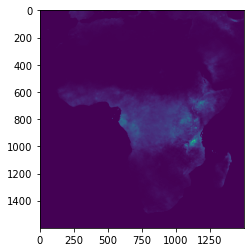

<AxesSubplot:>

In [12]:
d_from = datetime.date(2016,4,1)
d_to = datetime.date(2016,5,1)
april = c2.GetSumArray(d_from, d_to)
show(april)

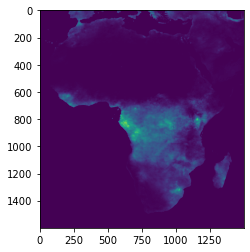

<AxesSubplot:>

In [219]:
d_from = datetime.date(2016,11,1)
d_to = datetime.date(2016,12,1)
nov = c2.GetSumArray(d_from, d_to)
show(nov)

Use the summariser to perform the required data extraction for the survey data

In [8]:
_folder = "/mnt/c/Users/harry/OneDrive - Nexus365/Informal_Cities/DHS_Data_And_Prep/AirPollution_Household_Extraction/Output"
_fn = "peak_urban_ssa_hh_coords_ET-fix_corrected.csv"

inp = os.path.join(_folder, _fn)

Read all the input data (required columns only)

In [34]:
df = pd.read_csv(inp
                 ,usecols=['surveyid','cluster_number','hhid', 'interview_date_clean', 'lat','lon'])
df['interview_date_parsed'] = pd.to_datetime(df['interview_date_clean'], format='%d/%m/%Y').dt.date
df=df[df['lat'].notna()]
df.head()

,surveyid,cluster_number,hhid,interview_date_clean,lat,lon,interview_date_parsed
0,211,1,117,26/10/2001,10.84476,2.109562,2001-10-26
1,211,1,1 1,26/10/2001,10.84476,2.109562,2001-10-26
2,211,1,1 2,26/10/2001,10.84476,2.109562,2001-10-26
3,211,1,1 3,26/10/2001,10.84476,2.109562,2001-10-26
4,211,1,1 4,26/10/2001,10.84476,2.109562,2001-10-26


The daily rasters for summarisation are different for each unique survey date. Get the list of unique dates.

In [12]:
unique_dates = df['interview_date_parsed'].unique()

Define a function to get the start / end date of a 30 period beginning (i * 30) days before the given date

In [10]:
def get_from_to(d, i):
    delta_from = datetime.timedelta(days=i*(-30))
    delta_to = datetime.timedelta(days=(i-1)*(-30))
    date_from = d + delta_from
    date_to = d + delta_to
    return date_from, date_to

## Perform the extraction 

For each date, filter the input dataframe to households surveyed on this date, then for each timestep generate the summary raster and sample it at the matching locations.

Running in a single process, this takes many hours for the ~4100 unique dates in our dataset.

We could parallelise across unique_dates using e.g. Dask. On this occasion we're going to use an alternate implementation in Earth Engine, and use this approach only to check the results.

In [26]:
for n_done, d in enumerate(unique_dates):
    grp = df.loc[df['interview_date_parsed'] == d][['lat','lon']]
    coords = list(zip(grp['lon'], grp['lat']))
    print(f"Step {n_done}: {d} ({len(coords)}): ",end="")
    for i in range(1,14):
        print(f"{i}...",end="")
        date_from, date_to = get_from_to(d, i)
        val_col = f"val_{i}"
        with c2.GetSumDataset(date_from, date_to) as ds:
            df.loc[df['interview_date_parsed'] == d, val_col] = [x[0] for x in ds.sample(coords, masked=True)]
    print("")
    df.loc[df['interview_date_parsed'] == d, '_done'] = True
    if n_done % 10 == 0:
        df.loc[df['_done']==True].to_csv(os.path.join(_folder, "intermediate_res.csv"))

Step 0: 2001-10-26 (66): 1...2...3...4...5...6...7...8...9...10...11...12...13...
Step 1: 2001-10-27 (44): 1...2...3...4...5...6...7...8...9...10...11...12...13...
Step 2: 2001-08-15 (81): 1...2...3...4...5...6...7...8...9...10...11...12...13...
Step 3: 2001-08-14 (76): 1...2...3...4...5...6...7...8...9...10...11...12...13...
Step 4: 2001-08-16 (70): 1...2...3...4...5...6...7...8...9...10...11...12...13...
Step 5: 2001-08-22 (63): 1...2...3...4...5...6...7...8...9...10...11...12...13...
Step 6: 2001-08-21 (79): 1...2...3...4...5...6...7...8...9...10...11...12...13...
Step 7: 2001-08-23 (71): 1...2...3...4...5...6...7...8...9...10...11...12...13...
Step 8: 2001-09-02 (58): 1...2...3...4...5...6...7...8...9...10...11...12...13...
Step 9: 2001-09-15 (41): 1...2...3...4...5...6...7...8...9...10...11...12...13...
Step 10: 2001-09-14 (67): 1...2...3...4...5...6...7...8...9...10...11...12...13...
Step 11: 2001-09-16 (68): 1...2...3...4...5...6...7...8...9...10...11...12...13...
Step 12: 2001-

ValueError: cannot convert float NaN to integer

In [36]:
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=10, progress_bar=True, use_memory_fs=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
